In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


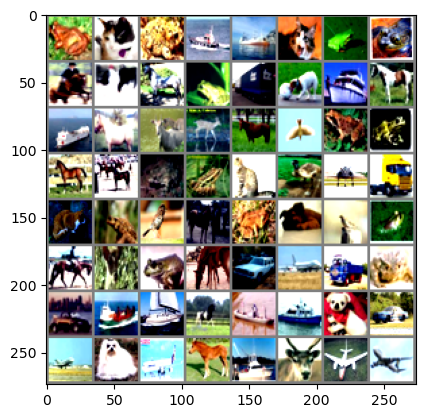

frog  cat   frog  ship  ship  cat   frog  frog  horse cat   horse frog  truck dog   ship  horse ship  horse deer  deer  horse bird  frog  frog  horse horse frog  frog  cat   bird  plane truck cat   frog  bird  horse frog  dog   bird  frog  horse deer  frog  horse car   plane truck frog  car   ship  ship  horse ship  ship  dog   car   plane dog   plane horse ship  deer  plane plane


In [10]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda')
net.to(device)


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net_old_exercize(nn.Module):
    def __init__(self):
        super(Net_old_exercize, self).__init__()
        
        # Updated for CIFAR-10: 3 input channels and adjusted output sizes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)   # Output: 30 x 30 x 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, stride=1)  # Output: 22 x 22 x 64
        
        # Max pooling reduces size from 22x22 to 11x11
        self.fc1 = nn.Linear(64 * 11 * 11, 128)  # Updated input size to 64 * 11 * 11 for CIFAR-10
        self.fc2 = nn.Linear(128, 10)            # Output for 10 CIFAR-10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)  # Reduces to 11 x 11 x 64
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output


In [12]:
import time
import matplotlib.pyplot as plt
import os

def train(net, optimizer, trainloader, criterion, scheduler, plateaux):  
    start_time = time.time()  # Start timing
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if scheduler is not None and not plateaux:
        scheduler.step()
    if scheduler is not None and plateaux:
        scheduler.step(running_loss / len(trainloader))

    epoch_time = time.time() - start_time  # Calculate elapsed time for this epoch
    print(f"Train epoch time: {epoch_time:.2f} seconds")
    
    return running_loss / len(trainloader), epoch_time  # Return the epoch time

def test(net, testloader, criterion):
    start_time = time.time()
    net.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(testloader)
    accuracy = 100 * correct / total
    test_time = time.time() - start_time
    print(f"Test time: {test_time:.2f} seconds")

    return accuracy, avg_test_loss

def train_and_plot(net, optimizer, trainloader, testloader, criterion, scheduler, plateaux, epochs, title):
    if not os.path.exists('plot_assignment2'):
        os.makedirs('plot_assignment2')

    train_losses = []
    test_losses = []
    test_accuracies = []
    total_training_time = 0  # Initialize cumulative training time

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        train_loss, epoch_time = train(net, optimizer, trainloader, criterion, scheduler, plateaux)
        total_training_time += epoch_time  # Add this epoch's time to the cumulative total

        accuracy, test_loss = test(net, testloader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds")

    # Display total training time for all epochs
    print(f"Total training time for {epochs} epochs: {total_training_time:.2f} seconds")

    # Plotting results
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()

    plt.suptitle(title)
    plot_path = os.path.join('plot_assignment2', f"{title.replace(' ', '_').lower()}.png")
    plt.savefig(plot_path)
    print(f"Plot saved as {plot_path}")

    plt.tight_layout()
    plt.show()


def class_accuracy(net, device, testloader):
    start_time = time.time()  # Start timing
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    accuracy_time = time.time() - start_time  # Calculate elapsed time
    print(f"Class accuracy time: {accuracy_time:.2f} seconds")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


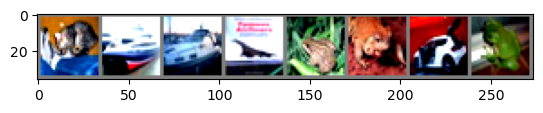

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:  deer  deer  deer  deer  plane deer  deer  deer 


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)
last_index = 8

# print images
imshow(torchvision.utils.make_grid(images[0:last_index]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(last_index)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(last_index)))

Epoch 1/20
Train epoch time: 15.22 seconds
Test time: 10.04 seconds
Train Loss: 1.7468, Test Loss: 1.5319, Test Accuracy: 44.34%
Epoch 1 completed in 15.22 seconds
Epoch 2/20
Train epoch time: 14.98 seconds
Test time: 10.17 seconds
Train Loss: 1.3792, Test Loss: 1.3759, Test Accuracy: 51.60%
Epoch 2 completed in 14.98 seconds
Epoch 3/20
Train epoch time: 15.15 seconds
Test time: 10.06 seconds
Train Loss: 1.2322, Test Loss: 1.2195, Test Accuracy: 56.45%
Epoch 3 completed in 15.15 seconds
Epoch 4/20
Train epoch time: 15.00 seconds
Test time: 10.02 seconds
Train Loss: 1.1154, Test Loss: 1.2497, Test Accuracy: 55.63%
Epoch 4 completed in 15.00 seconds
Epoch 5/20
Train epoch time: 15.12 seconds
Test time: 10.04 seconds
Train Loss: 1.0180, Test Loss: 1.0550, Test Accuracy: 62.65%
Epoch 5 completed in 15.12 seconds
Epoch 6/20
Train epoch time: 15.21 seconds
Test time: 10.14 seconds
Train Loss: 0.9327, Test Loss: 1.0599, Test Accuracy: 63.18%
Epoch 6 completed in 15.21 seconds
Epoch 7/20
Train

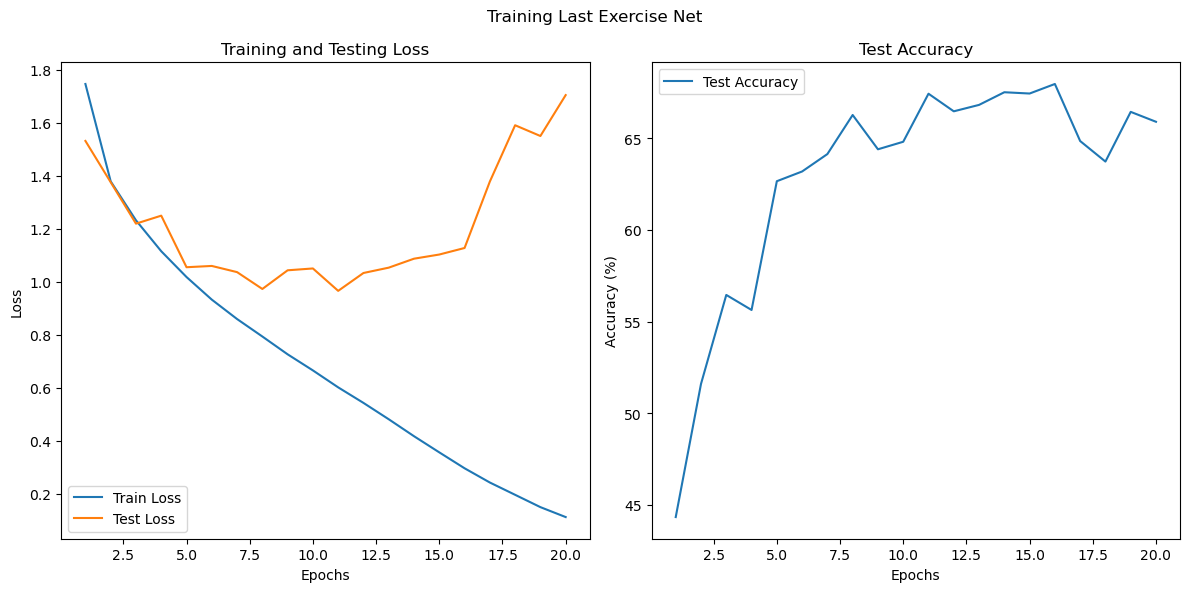

Accuracy for class: plane is 63.2 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 55.7 %
Accuracy for class: cat   is 26.3 %
Accuracy for class: deer  is 78.0 %
Accuracy for class: dog   is 50.1 %
Accuracy for class: frog  is 80.6 %
Accuracy for class: horse is 74.2 %
Accuracy for class: ship  is 80.9 %
Accuracy for class: truck is 74.0 %
Class accuracy time: 10.75 seconds


In [15]:
net = Net_old_exercize().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-4)

train_and_plot(net, optimizer, trainloader, testloader, criterion, None, False, epochs=20, title="Training Last Exercise Net")
class_accuracy(net, device, testloader)

Epoch 1/20
Train epoch time: 12.83 seconds
Test time: 9.67 seconds
Train Loss: 2.2264, Test Loss: 2.0196, Test Accuracy: 26.66%
Epoch 1 completed in 12.83 seconds
Epoch 2/20
Train epoch time: 12.46 seconds
Test time: 9.74 seconds
Train Loss: 1.8415, Test Loss: 1.6628, Test Accuracy: 38.46%
Epoch 2 completed in 12.46 seconds
Epoch 3/20
Train epoch time: 12.42 seconds
Test time: 9.66 seconds
Train Loss: 1.5962, Test Loss: 1.5594, Test Accuracy: 42.93%
Epoch 3 completed in 12.42 seconds
Epoch 4/20
Train epoch time: 12.51 seconds
Test time: 9.69 seconds
Train Loss: 1.4883, Test Loss: 1.6382, Test Accuracy: 42.63%
Epoch 4 completed in 12.51 seconds
Epoch 5/20
Train epoch time: 12.47 seconds
Test time: 9.69 seconds
Train Loss: 1.4096, Test Loss: 1.5460, Test Accuracy: 44.79%
Epoch 5 completed in 12.47 seconds
Epoch 6/20
Train epoch time: 12.59 seconds
Test time: 9.67 seconds
Train Loss: 1.3500, Test Loss: 1.4036, Test Accuracy: 50.06%
Epoch 6 completed in 12.59 seconds
Epoch 7/20
Train epoch

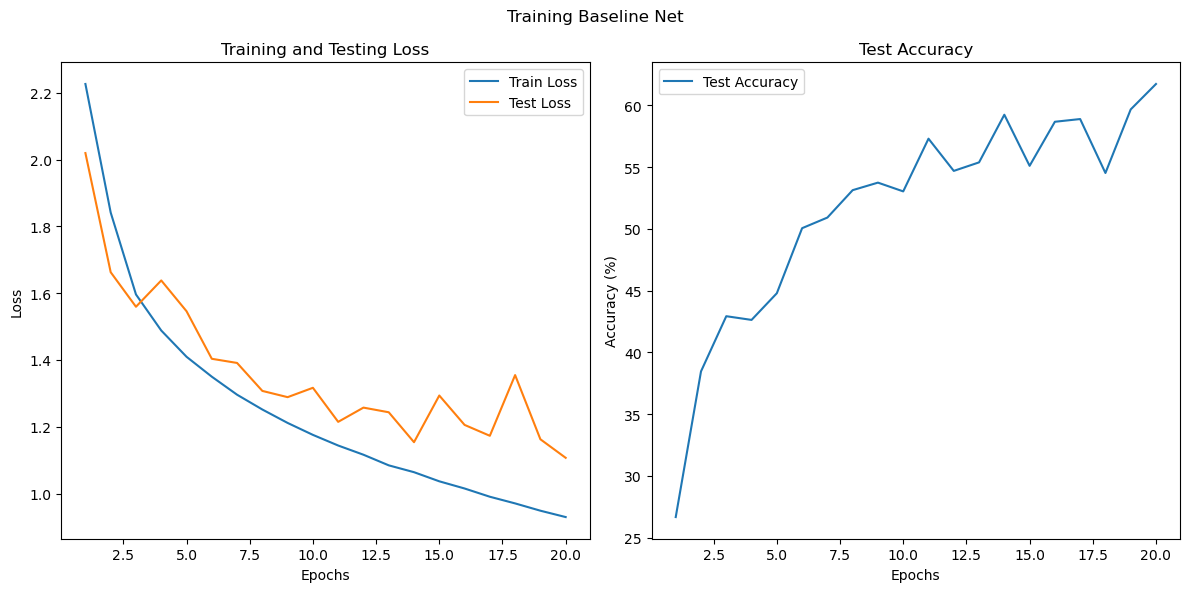

Accuracy for class: plane is 73.3 %
Accuracy for class: car   is 66.2 %
Accuracy for class: bird  is 52.1 %
Accuracy for class: cat   is 31.4 %
Accuracy for class: deer  is 49.2 %
Accuracy for class: dog   is 46.1 %
Accuracy for class: frog  is 72.6 %
Accuracy for class: horse is 85.1 %
Accuracy for class: ship  is 76.4 %
Accuracy for class: truck is 65.0 %
Class accuracy time: 10.41 seconds


In [16]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.1)

train_and_plot(net, optimizer, trainloader, testloader, criterion, None, False, epochs=20, title="Training Baseline Net")
class_accuracy(net, device, testloader)

Epoch 1/20
Train epoch time: 12.69 seconds
Test time: 9.62 seconds
Train Loss: 2.2029, Test Loss: 2.0250, Test Accuracy: 26.52%
Epoch 1 completed in 12.69 seconds
Epoch 2/20
Train epoch time: 12.56 seconds
Test time: 9.67 seconds
Train Loss: 1.9396, Test Loss: 1.8138, Test Accuracy: 33.71%
Epoch 2 completed in 12.56 seconds
Epoch 3/20
Train epoch time: 12.48 seconds
Test time: 9.70 seconds
Train Loss: 1.6870, Test Loss: 1.6530, Test Accuracy: 39.53%
Epoch 3 completed in 12.48 seconds
Epoch 4/20
Train epoch time: 12.37 seconds
Test time: 9.63 seconds
Train Loss: 1.5211, Test Loss: 1.5174, Test Accuracy: 44.28%
Epoch 4 completed in 12.37 seconds
Epoch 5/20
Train epoch time: 12.53 seconds
Test time: 9.67 seconds
Train Loss: 1.4332, Test Loss: 1.5735, Test Accuracy: 43.13%
Epoch 5 completed in 12.53 seconds
Epoch 6/20
Train epoch time: 12.48 seconds
Test time: 9.72 seconds
Train Loss: 1.3657, Test Loss: 1.3737, Test Accuracy: 50.90%
Epoch 6 completed in 12.48 seconds
Epoch 7/20
Train epoch

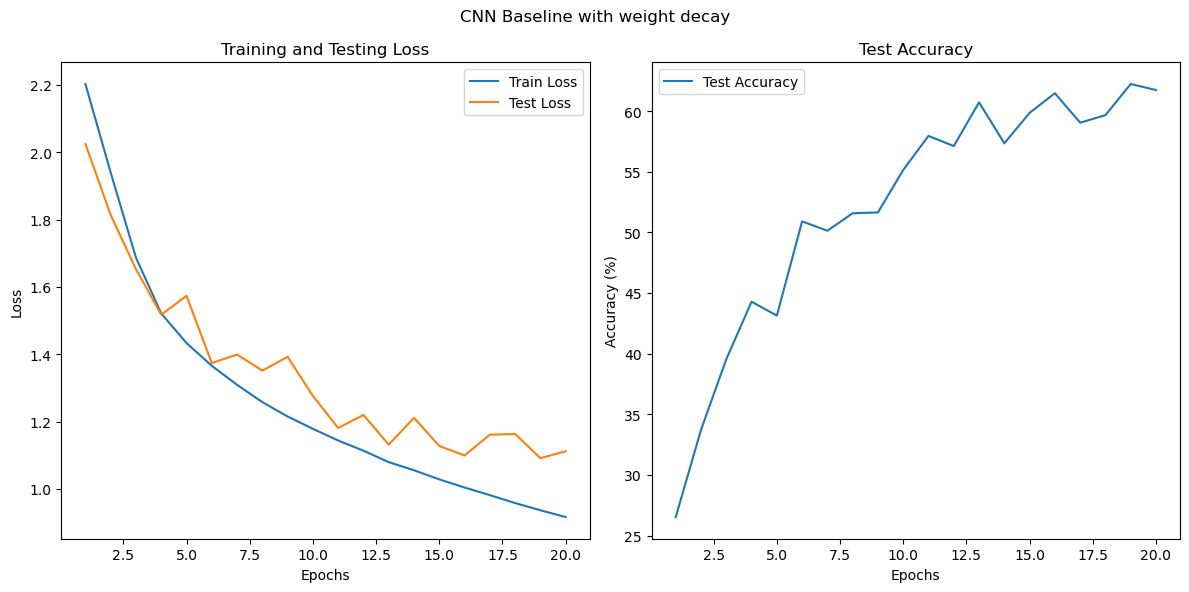

Accuracy for class: plane is 55.3 %
Accuracy for class: car   is 74.6 %
Accuracy for class: bird  is 39.5 %
Accuracy for class: cat   is 47.3 %
Accuracy for class: deer  is 60.3 %
Accuracy for class: dog   is 37.1 %
Accuracy for class: frog  is 70.2 %
Accuracy for class: horse is 77.5 %
Accuracy for class: ship  is 75.3 %
Accuracy for class: truck is 80.2 %
Class accuracy time: 10.46 seconds


In [17]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-4)

train_and_plot(net, optimizer, trainloader, testloader, criterion, None, False, epochs=20, title="CNN Baseline with weight decay")
class_accuracy(net, device, testloader)

## Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.

In [18]:
import numpy as np

mean = np.mean(trainset.data / 255, axis=(0, 1, 2))
std = np.std(trainset.data / 255, axis=(0, 1, 2))
print('Mean: ', mean), print('std: ', std)

Mean:  [0.49139968 0.48215841 0.44653091]
std:  [0.24703223 0.24348513 0.26158784]


(None, None)

### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

Epoch 1/20
Train epoch time: 15.26 seconds
Test time: 9.84 seconds
Train Loss: 1.6091, Test Loss: 2.0151, Test Accuracy: 38.20%
Epoch 1 completed in 15.26 seconds
Epoch 2/20
Train epoch time: 14.76 seconds
Test time: 9.82 seconds
Train Loss: 1.0635, Test Loss: 1.0810, Test Accuracy: 61.94%
Epoch 2 completed in 14.76 seconds
Epoch 3/20
Train epoch time: 14.79 seconds
Test time: 9.81 seconds
Train Loss: 0.9713, Test Loss: 1.0439, Test Accuracy: 62.55%
Epoch 3 completed in 14.79 seconds
Epoch 4/20
Train epoch time: 14.78 seconds
Test time: 9.83 seconds
Train Loss: 0.9065, Test Loss: 1.0518, Test Accuracy: 62.78%
Epoch 4 completed in 14.78 seconds
Epoch 5/20
Train epoch time: 14.76 seconds
Test time: 9.81 seconds
Train Loss: 0.8457, Test Loss: 1.0174, Test Accuracy: 64.58%
Epoch 5 completed in 14.76 seconds
Epoch 6/20
Train epoch time: 14.77 seconds
Test time: 9.84 seconds
Train Loss: 0.7908, Test Loss: 1.0118, Test Accuracy: 65.47%
Epoch 6 completed in 14.77 seconds
Epoch 7/20
Train epoch

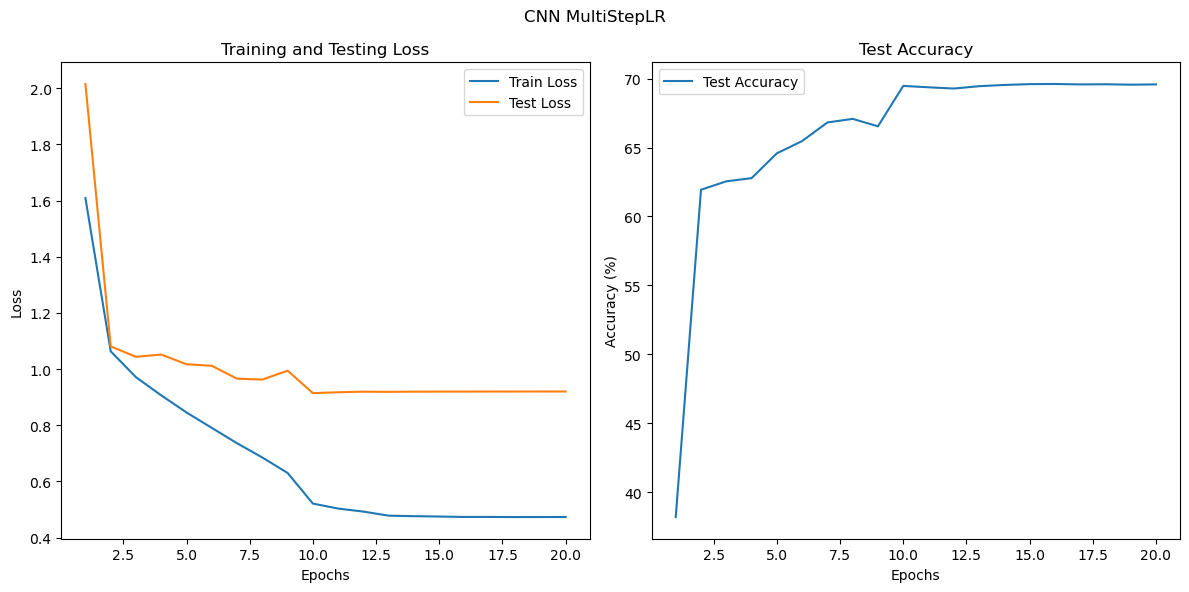

Accuracy for class: plane is 75.6 %
Accuracy for class: car   is 80.6 %
Accuracy for class: bird  is 56.4 %
Accuracy for class: cat   is 51.3 %
Accuracy for class: deer  is 63.4 %
Accuracy for class: dog   is 57.1 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 75.1 %
Accuracy for class: ship  is 80.8 %
Accuracy for class: truck is 77.7 %
Class accuracy time: 10.57 seconds


In [19]:
""" Example of usage
    >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    >>> for epoch in range(100):
    >>>     train(...)
    >>>     test(...)
    >>>     scheduler.step()
"""

from torch.optim.lr_scheduler import MultiStepLR

epoch=20
net = Net_old_exercize().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.1, weight_decay=1e-4)
schedulerMS = MultiStepLR(optimizer, milestones=[1,9,12,15], gamma=0.1)
criterion = nn.CrossEntropyLoss()


train_and_plot(net,optimizer,trainloader,testloader,criterion,schedulerMS,False,epoch,'CNN MultiStepLR')
class_accuracy(net, device, testloader)

Epoch 1/20
Train epoch time: 12.71 seconds
Test time: 9.61 seconds
Train Loss: 1.7470, Test Loss: 1.4746, Test Accuracy: 46.57%
Epoch 1 completed in 12.71 seconds
Epoch 2/20
Train epoch time: 12.44 seconds
Test time: 9.71 seconds
Train Loss: 1.3562, Test Loss: 1.3419, Test Accuracy: 52.13%
Epoch 2 completed in 12.44 seconds
Epoch 3/20
Train epoch time: 12.42 seconds
Test time: 9.62 seconds
Train Loss: 1.2260, Test Loss: 1.1942, Test Accuracy: 57.96%
Epoch 3 completed in 12.42 seconds
Epoch 4/20
Train epoch time: 12.46 seconds
Test time: 9.62 seconds
Train Loss: 1.1230, Test Loss: 1.1667, Test Accuracy: 59.41%
Epoch 4 completed in 12.46 seconds
Epoch 5/20
Train epoch time: 12.55 seconds
Test time: 9.61 seconds
Train Loss: 1.0549, Test Loss: 1.1514, Test Accuracy: 60.28%
Epoch 5 completed in 12.55 seconds
Epoch 6/20
Train epoch time: 12.61 seconds
Test time: 9.75 seconds
Train Loss: 0.9835, Test Loss: 1.0774, Test Accuracy: 62.71%
Epoch 6 completed in 12.61 seconds
Epoch 7/20
Train epoch

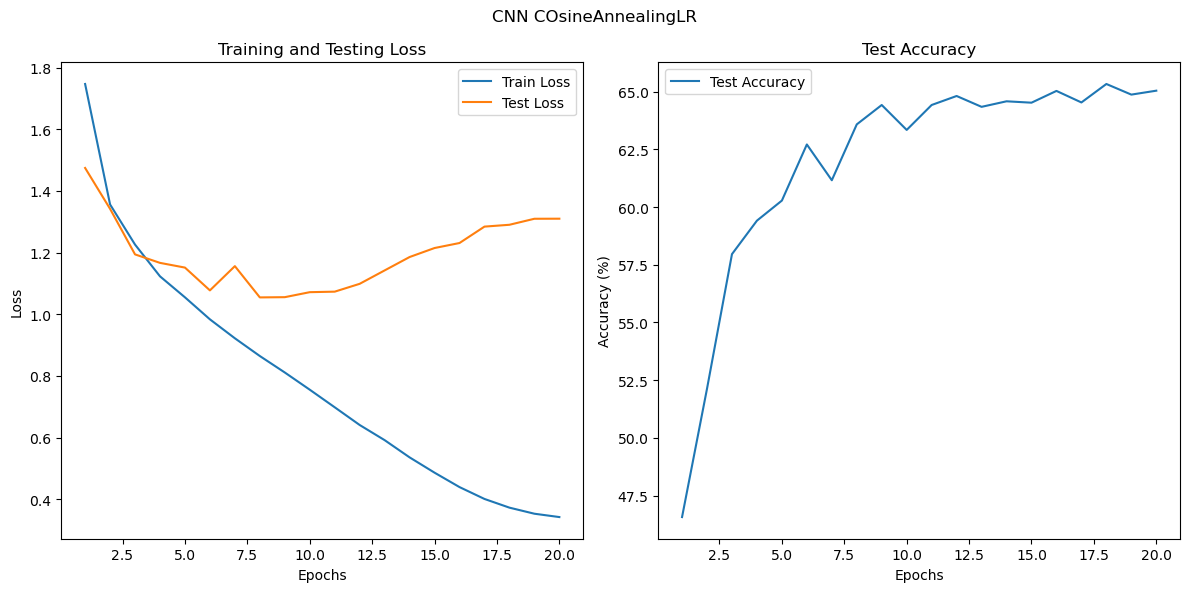

Accuracy for class: plane is 68.5 %
Accuracy for class: car   is 76.7 %
Accuracy for class: bird  is 55.3 %
Accuracy for class: cat   is 46.4 %
Accuracy for class: deer  is 59.0 %
Accuracy for class: dog   is 52.3 %
Accuracy for class: frog  is 74.4 %
Accuracy for class: horse is 68.8 %
Accuracy for class: ship  is 77.0 %
Accuracy for class: truck is 72.0 %
Class accuracy time: 10.55 seconds


In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR

epoch = 20
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=epoch)  # T_max is the maximum number of iterations (epochs)
criterion = nn.CrossEntropyLoss()

train_and_plot(net, optimizer, trainloader, testloader, criterion, scheduler_cosine, False, epochs=epoch, title="CNN COsineAnnealingLR")
class_accuracy(net, device, testloader)


Epoch 1/20
Train epoch time: 12.66 seconds
Test time: 9.58 seconds
Train Loss: 2.0142, Test Loss: 1.9284, Test Accuracy: 27.81%
Epoch 1 completed in 12.66 seconds
Epoch 2/20
Train epoch time: 12.48 seconds
Test time: 9.63 seconds
Train Loss: 1.9716, Test Loss: 1.9576, Test Accuracy: 28.24%
Epoch 2 completed in 12.48 seconds
Epoch 3/20
Train epoch time: 12.54 seconds
Test time: 9.68 seconds
Train Loss: 1.9490, Test Loss: 1.9318, Test Accuracy: 28.18%
Epoch 3 completed in 12.54 seconds
Epoch 4/20
Train epoch time: 12.30 seconds
Test time: 9.63 seconds
Train Loss: 1.9397, Test Loss: 1.9558, Test Accuracy: 26.44%
Epoch 4 completed in 12.30 seconds
Epoch 5/20
Train epoch time: 12.48 seconds
Test time: 9.62 seconds
Train Loss: 1.9458, Test Loss: 1.9905, Test Accuracy: 25.22%
Epoch 5 completed in 12.48 seconds
Epoch 6/20
Train epoch time: 12.47 seconds
Test time: 9.68 seconds
Train Loss: 1.9542, Test Loss: 2.3090, Test Accuracy: 15.74%
Epoch 6 completed in 12.47 seconds
Epoch 7/20
Train epoch

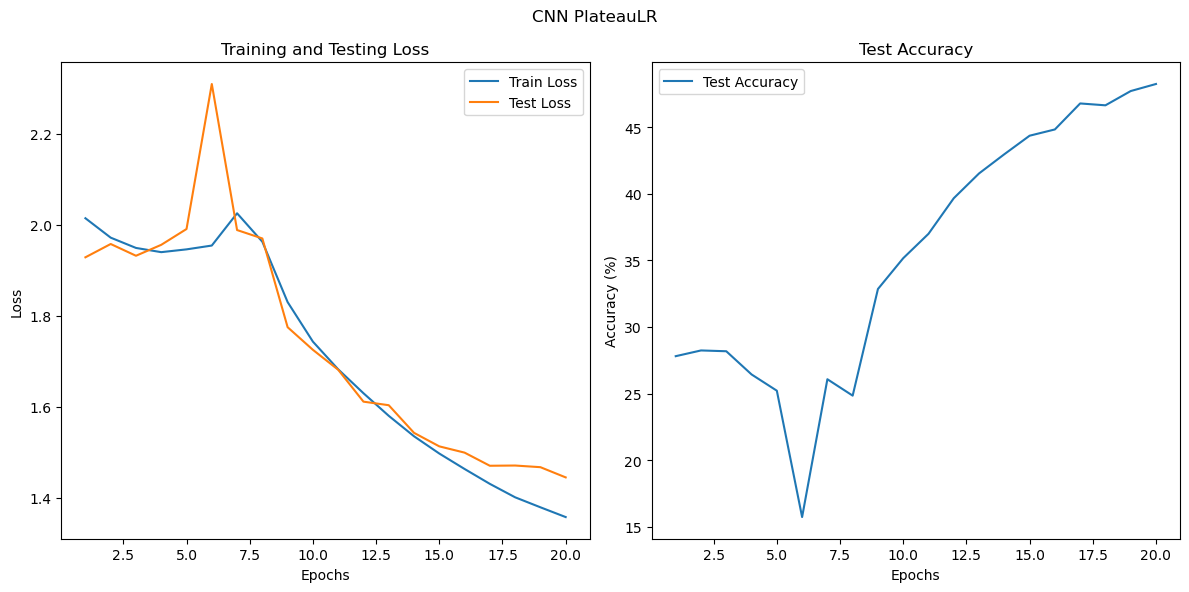

Accuracy for class: plane is 52.1 %
Accuracy for class: car   is 59.2 %
Accuracy for class: bird  is 25.1 %
Accuracy for class: cat   is 36.4 %
Accuracy for class: deer  is 47.4 %
Accuracy for class: dog   is 37.0 %
Accuracy for class: frog  is 57.8 %
Accuracy for class: horse is 48.4 %
Accuracy for class: ship  is 66.5 %
Accuracy for class: truck is 52.4 %
Class accuracy time: 10.33 seconds


In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

epoch = 20
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler_cosine = ReduceLROnPlateau(optimizer, patience=3)  # T_max is the maximum number of iterations (epochs)
criterion = nn.CrossEntropyLoss()

train_and_plot(net, optimizer, trainloader, testloader, criterion, scheduler_cosine, True, epochs=epoch, title="CNN PlateauLR")
class_accuracy(net, device, testloader)

## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [22]:
transform2 = transforms.Compose([
                        ## add more here
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomCrop(32, padding=4),  
                        #transforms.RandomRotation(15),
                        #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        #transforms.GaussianBlur(kernel_size=5),
                        transforms.ToTensor(),
                        transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                        ])


trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset2, batch_size=64, shuffle=True, num_workers=4)


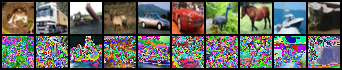

In [23]:
# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [24]:

epoch=20
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Epoch 1/20
Train epoch time: 12.96 seconds
Test time: 9.58 seconds
Train Loss: 2.0617, Test Loss: 1.9743, Test Accuracy: 22.93%
Epoch 1 completed in 12.96 seconds
Epoch 2/20
Train epoch time: 12.83 seconds
Test time: 9.54 seconds
Train Loss: 1.8592, Test Loss: 1.7607, Test Accuracy: 32.56%
Epoch 2 completed in 12.83 seconds
Epoch 3/20
Train epoch time: 12.84 seconds
Test time: 9.69 seconds
Train Loss: 1.7399, Test Loss: 1.6225, Test Accuracy: 39.10%
Epoch 3 completed in 12.84 seconds
Epoch 4/20
Train epoch time: 12.92 seconds
Test time: 9.71 seconds
Train Loss: 1.6368, Test Loss: 1.5369, Test Accuracy: 43.17%
Epoch 4 completed in 12.92 seconds
Epoch 5/20
Train epoch time: 12.99 seconds
Test time: 9.65 seconds
Train Loss: 1.5715, Test Loss: 1.4786, Test Accuracy: 46.85%
Epoch 5 completed in 12.99 seconds
Epoch 6/20
Train epoch time: 12.83 seconds
Test time: 9.57 seconds
Train Loss: 1.5218, Test Loss: 1.4310, Test Accuracy: 48.47%
Epoch 6 completed in 12.83 seconds
Epoch 7/20
Train epoch

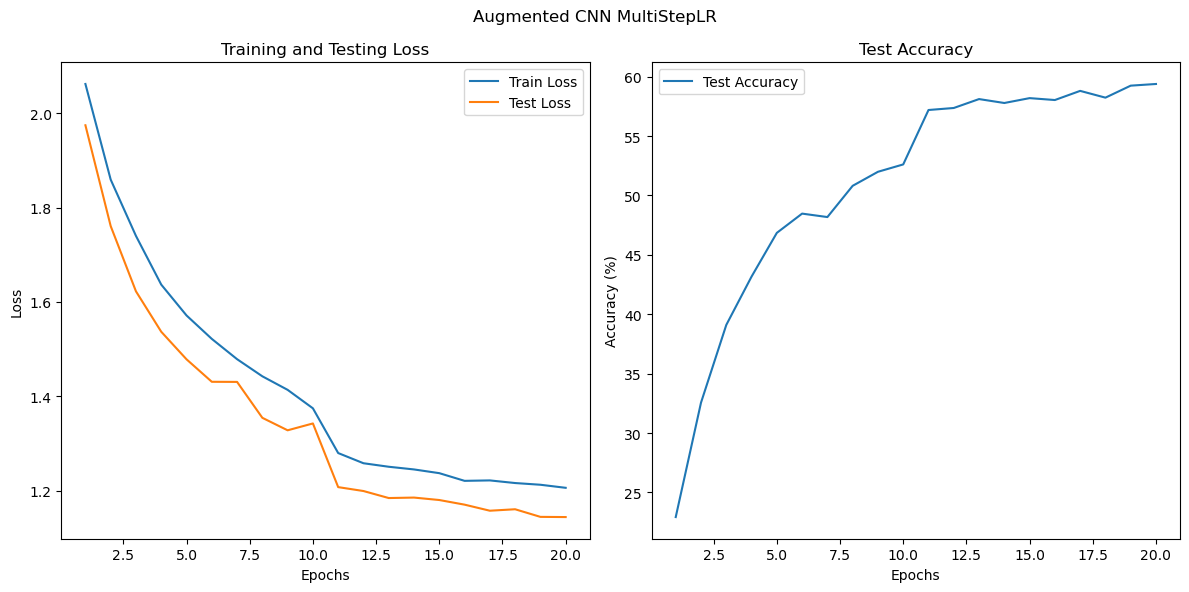

Accuracy for class: plane is 67.3 %
Accuracy for class: car   is 72.2 %
Accuracy for class: bird  is 47.1 %
Accuracy for class: cat   is 32.1 %
Accuracy for class: deer  is 45.1 %
Accuracy for class: dog   is 51.9 %
Accuracy for class: frog  is 70.5 %
Accuracy for class: horse is 67.2 %
Accuracy for class: ship  is 73.8 %
Accuracy for class: truck is 66.6 %
Class accuracy time: 10.76 seconds


In [25]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
schedulerMS = MultiStepLR(optimizer, milestones=[1,10], gamma=0.1)

train_and_plot(net,optimizer,trainloader,testloader,criterion,schedulerMS,False,epoch,'Augmented CNN MultiStepLR')
class_accuracy(net, device, testloader)

In [26]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=epoch) 
train_and_plot(net,optimizer,trainloader,testloader,criterion,scheduler_cosine,False,epoch,'Augmented CNN CosineAnnealingLR')
class_accuracy(net, device, testloader)


Epoch 1/20
Train epoch time: 13.65 seconds


KeyboardInterrupt: 

Epoch 1/20
Train epoch time: 13.16 seconds
Test time: 9.64 seconds
Train Loss: 2.0740, Test Loss: 2.0526, Test Accuracy: 18.01%
Epoch 1 completed in 22.80 seconds
Epoch 2/20
Train epoch time: 13.43 seconds
Test time: 9.72 seconds
Train Loss: 2.0305, Test Loss: 1.9752, Test Accuracy: 24.56%
Epoch 2 completed in 23.15 seconds
Epoch 3/20
Train epoch time: 13.00 seconds
Test time: 9.74 seconds
Train Loss: 2.0071, Test Loss: 1.9484, Test Accuracy: 26.07%
Epoch 3 completed in 22.74 seconds
Epoch 4/20
Train epoch time: 12.96 seconds
Test time: 9.71 seconds
Train Loss: 2.0386, Test Loss: 2.0522, Test Accuracy: 19.55%
Epoch 4 completed in 22.67 seconds
Epoch 5/20
Train epoch time: 12.94 seconds
Test time: 9.78 seconds
Train Loss: 2.0525, Test Loss: 2.0143, Test Accuracy: 24.50%
Epoch 5 completed in 22.72 seconds
Epoch 6/20
Train epoch time: 12.99 seconds
Test time: 9.70 seconds
Train Loss: 2.0648, Test Loss: 2.0662, Test Accuracy: 21.21%
Epoch 6 completed in 22.69 seconds
Epoch 7/20
Train epoch

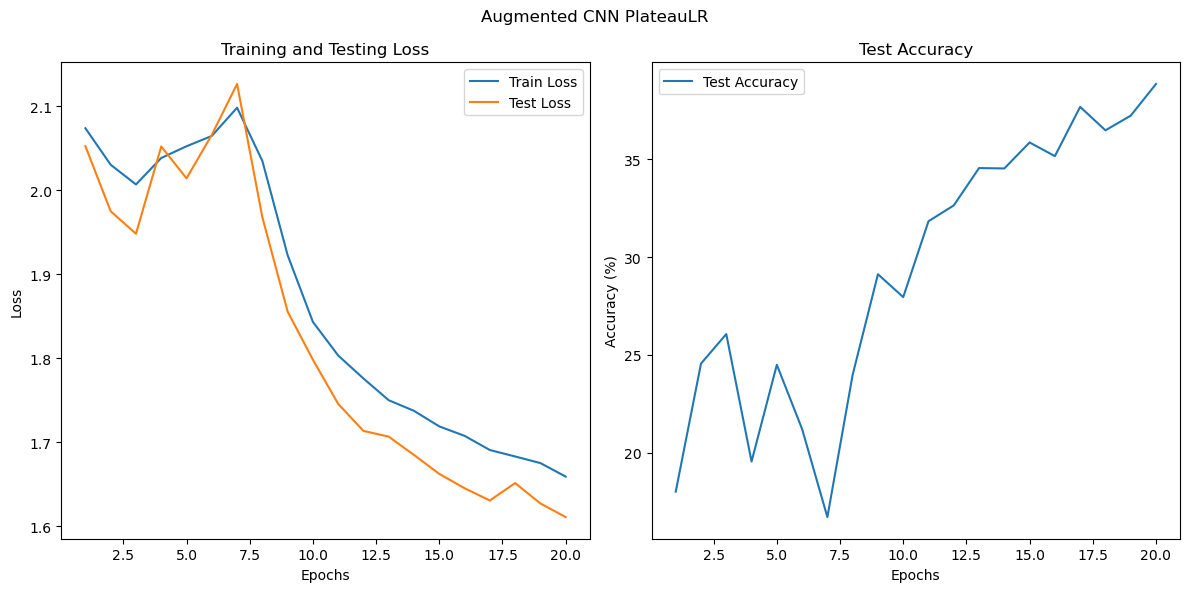

Accuracy for class: plane is 51.6 %
Accuracy for class: car   is 34.9 %
Accuracy for class: bird  is 14.9 %
Accuracy for class: cat   is 13.9 %
Accuracy for class: deer  is 45.6 %
Accuracy for class: dog   is 51.3 %
Accuracy for class: frog  is 31.7 %
Accuracy for class: horse is 41.0 %
Accuracy for class: ship  is 47.9 %
Accuracy for class: truck is 55.8 %
Class accuracy time: 10.45 seconds


In [24]:

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler_cosine = ReduceLROnPlateau(optimizer, patience=3)  # T_max is the maximum number of iterations (epochs)
train_and_plot(net,optimizer,trainloader,testloader,criterion,scheduler_cosine,True,epoch,'Augmented CNN PlateauLR')
class_accuracy(net, device, testloader)

Now use it to train the your model

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [25]:
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        
        # Architecture with 11 layers and batch normalization
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for fc1
        
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)  # Batch normalization for fc2
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization for fc3
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)  # Batch normalization for fc4
        
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)  # Batch normalization for fc5
        
        self.fc6 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)  # Batch normalization for fc6
        
        self.fc7 = nn.Linear(512, 128)
        self.bn7 = nn.BatchNorm1d(128)  # Batch normalization for fc7
        
        self.fc8 = nn.Linear(128, 128)
        self.bn8 = nn.BatchNorm1d(128)  # Batch normalization for fc8
        
        self.fc9 = nn.Linear(128, 64)
        self.bn9 = nn.BatchNorm1d(64)   # Batch normalization for fc9
        
        self.fc10 = nn.Linear(64, 32)
        self.bn10 = nn.BatchNorm1d(32)  # Batch normalization for fc10
        
        self.fc11 = nn.Linear(32, 10)   # Output layer

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        # Passing through fully connected layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        
        # Output layer with log_softmax for classification
        x = F.log_softmax(self.fc11(x), dim=1)
        return x
    
# Initialize model, optimizer, and run training and testing
net = Net_Deeper().to(device)
optimizer = optim.SGD(net.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=15)
train_and_plot(net,optimizer,trainloader,testloader,criterion,scheduler,False,15,'Augmented FC CosineAnnealingLR')
class_accuracy(net, device, testloader)

Epoch 1/15


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x3072 and 784x512)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BigCNN(nn.Module):
    def __init__(self):
        super(BigCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 10 output classes for CIFAR-10

        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)


        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layers

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, as it's passed to CrossEntropyLoss

        return x


model = BigCNN().to(device)
optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9,weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=15)
train_and_plot(net,optimizer,trainloader,testloader,criterion,scheduler,False,epoch,'Augmented new CNN CosineAnnealingLR')
class_accuracy(net, device, testloader)

In [16]:
import torchvision.models as models

alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()


In [ ]:

resnet18.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18.to(device)
optimizer = optim.SGD(resnet18.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

train_and_plot(net,optimizer,trainloader,testloader,criterion,scheduler,False,epoch,'Resnet18 CosineAnnealingLR')
class_accuracy(net, device, testloader)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = AlexNet(10).to(device)

optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

train_and_plot(model,optimizer,trainloader,testloader,criterion,scheduler,False,epoch,'Resnet18 CosineAnnealingLR')
class_accuracy(model, device, testloader)

In [5]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
epoch=20

def modify_vgg16_for_cifar10():
    # Load the VGG16 model
    model = models.vgg16(pretrained=False)
    
    # Modify the classifier to fit CIFAR-10's 32x32 images
    # Forward a dummy input through the feature layers to get the flattened size
    dummy_input = torch.randn(1, 3, 32, 32)  # CIFAR-10 image size
    features_output = model.features(dummy_input)
    flattened_size = features_output.view(-1).shape[0]  # Calculate flattened size

    # Adjust the classifier
    model.classifier[0] = nn.Linear(flattened_size, 4096)
    model.classifier[6] = nn.Linear(4096, 10)  # Output layer for 10 classes
    
    return model

# Instantiate the modified model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modify_vgg16_for_cifar10().to(device)

optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

train_and_plot(model,optimizer,trainloader,testloader,criterion,scheduler,False,epoch,'Resnet18 CosineAnnealingLR')
class_accuracy(model, device, testloader)


c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


NameError: name 'train_and_plot' is not defined